In [15]:
import tensorflow as tf 
import numpy as np
import matplotlib
from matplotlib import pyplot

from keras.models import Sequential
from keras.datasets.cifar10 import load_data
from keras.layers import Conv2D,Conv2DTranspose,Dense,ReLU,LeakyReLU,Flatten,Reshape,Dropout
from keras.optimizers import Adam

In [16]:
(x_train,y_train), (x_test,y_test) = load_data()


In [17]:
x_train.shape

(50000, 32, 32, 3)

In [51]:

def discriminator():
	model = Sequential()
	model.add(Conv2D(64,(3,3),padding='same',input_shape = (32,32,3)))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))
	
	model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))
	model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))

	
	model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))

	model.add(Dense(1,activation = 'sigmoid'))
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)

	model.compile(optimizer= optimus , loss = 'binary_crossentropy' , metrics= ['accuracy'])
	return model

In [52]:
def generator(laten_dim ):
	model = Sequential()
	model.add(Dense(4*4*256 ,input_dim = laten_dim))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Reshape((4,4,256)))
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	
	model.add(Conv2D(3,(3,3),activation='tanh',padding = 'same'))

	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)

	model.compile(optimizer= optimus , loss = 'binary_crossentropy' )
	return model


In [53]:

def gan(g_model,d_model):
    
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)
	model.compile(optimizer = optimus,loss= 'binary_crossentropy'  )
	return model

In [34]:

def load_real_samples():

	(x_train,_),(_,_) = load_data()
	x_train  = x_train.astype('float32')

	x_train = (x_train-127.5)/127.5
	return x_train

In [35]:

def generate_real_samples(dataset , n_samples):

	for i in range (n_samples):
		index = np.random.randint(0 , dataset.shape[0] , n_samples)

		image = dataset[index]
		y = np.ones((n_samples,1))

		return image,y

In [36]:

def generate_latent_sample(laten_dim,n_samples):
	
	x = np.random.randn(laten_dim*n_samples)
	x = x.reshape(n_samples,laten_dim)

	return x

In [37]:

def generate_fake_samples(g_model, latent_dim,n_samples):
	
	x = generate_latent_sample(latent_dim,n_samples)
	x = g_model.predict(x)
	y = np.zeros((n_samples,1))

	return x,y

In [38]:
def save_plot(examples ,epoch , n = 7):
	examples = (examples+1) / 2.0

	for i in range(n*n):
		pyplot.subplot(n,n,1+i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%0.3d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [39]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples = 150):

	x_real ,y_real = generate_real_samples(dataset,n_samples)
	_,acc_real = d_model.evaluate(x_real,y_real)

	x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
	_,acc_fake = d_model.evaluate(x_fake,y_fake)

	print(('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)))
	save_plot(x_fake,epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)



In [55]:
def train(g_model,d_model,gan_model, dataset ,latent_dim, n_epoch = 30, n_batch = 128):
	batch_per_epoch = int(dataset.shape[0]/n_batch)
	batch = int(n_batch/2)

	for i in range(n_epoch):
		for j in range (batch_per_epoch):

			x_real,y_real = generate_real_samples(dataset,batch)

			d_model_loss1,_ = d_model.train_on_batch(x_real,y_real)

			x_fake ,y_fake = generate_fake_samples(g_model,latent_dim,batch)

			d_model_loss2,_ =d_model.train_on_batch(x_fake,y_fake)

			x_gan = generate_latent_sample(latent_dim, n_batch)
			y_gan = np.ones((n_batch,1))

			g_model_loss = gan_model.train_on_batch(x_gan,y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f'% 
                  (i+1, j+1, batch_per_epoch, d_model_loss1, d_model_loss2, g_model_loss))
		if (i+1) % 3 ==0 :
			summarize_performance(i,g_model,d_model,dataset,latent_dim)


In [56]:

latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model,d_model)

d_model.summary()
g_model.summary()
dataset = load_real_samples()

train(g_model,d_model,gan_model,dataset,latent_dim)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 256)       

C:\Users\samya\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/390, d1=0.711, d2=0.695 g=0.692


C:\Users\samya\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/390, d1=0.650, d2=0.697 g=0.690
>1, 3/390, d1=0.594, d2=0.702 g=0.685
>1, 4/390, d1=0.518, d2=0.715 g=0.674
>1, 5/390, d1=0.408, d2=0.743 g=0.652
>1, 6/390, d1=0.300, d2=0.802 g=0.616
>1, 7/390, d1=0.220, d2=0.872 g=0.597
>1, 8/390, d1=0.167, d2=0.887 g=0.623
>1, 9/390, d1=0.187, d2=0.826 g=0.686
>1, 10/390, d1=0.172, d2=0.715 g=0.795
>1, 11/390, d1=0.130, d2=0.593 g=0.951
>1, 12/390, d1=0.191, d2=0.529 g=1.010
>1, 13/390, d1=0.171, d2=0.538 g=0.957
>1, 14/390, d1=0.132, d2=0.571 g=0.893
>1, 15/390, d1=0.096, d2=0.600 g=0.846
>1, 16/390, d1=0.161, d2=0.636 g=0.802
>1, 17/390, d1=0.064, d2=0.664 g=0.792
>1, 18/390, d1=0.039, d2=0.713 g=0.787
>1, 19/390, d1=0.022, d2=0.876 g=0.734
>1, 20/390, d1=0.039, d2=1.189 g=0.673
>1, 21/390, d1=0.042, d2=1.088 g=0.827
>1, 22/390, d1=0.058, d2=0.653 g=1.227
>1, 23/390, d1=0.175, d2=0.468 g=1.332
>1, 24/390, d1=0.298, d2=0.616 g=1.000
>1, 25/390, d1=0.192, d2=0.757 g=0.868
>1, 26/390, d1=0.173, d2=0.754 g=0.861
>1, 27/390, d1=0.073, d2=0.633 g=

>1, 210/390, d1=0.256, d2=0.265 g=2.284
>1, 211/390, d1=0.194, d2=0.163 g=2.457
>1, 212/390, d1=0.249, d2=0.152 g=2.459
>1, 213/390, d1=0.230, d2=0.143 g=2.554
>1, 214/390, d1=0.226, d2=0.161 g=2.290
>1, 215/390, d1=0.213, d2=0.185 g=2.336
>1, 216/390, d1=0.273, d2=0.204 g=2.152
>1, 217/390, d1=0.169, d2=0.221 g=2.137
>1, 218/390, d1=0.221, d2=0.272 g=1.974
>1, 219/390, d1=0.372, d2=0.333 g=1.980
>1, 220/390, d1=0.272, d2=0.379 g=2.042
>1, 221/390, d1=0.351, d2=0.296 g=2.070
>1, 222/390, d1=0.217, d2=0.377 g=2.175
>1, 223/390, d1=0.382, d2=0.370 g=2.119
>1, 224/390, d1=0.339, d2=0.351 g=2.084
>1, 225/390, d1=0.255, d2=0.301 g=2.084
>1, 226/390, d1=0.308, d2=0.252 g=2.163
>1, 227/390, d1=0.437, d2=0.288 g=2.005
>1, 228/390, d1=0.272, d2=0.239 g=2.125
>1, 229/390, d1=0.232, d2=0.237 g=2.263
>1, 230/390, d1=0.227, d2=0.202 g=2.329
>1, 231/390, d1=0.467, d2=0.336 g=2.148
>1, 232/390, d1=0.480, d2=0.393 g=2.103
>1, 233/390, d1=0.253, d2=0.370 g=2.732
>1, 234/390, d1=0.431, d2=0.263 g=2.959


>2, 26/390, d1=0.378, d2=0.412 g=1.516
>2, 27/390, d1=0.437, d2=0.494 g=1.495
>2, 28/390, d1=0.419, d2=0.498 g=1.579
>2, 29/390, d1=0.371, d2=0.341 g=1.619
>2, 30/390, d1=0.450, d2=0.409 g=1.564
>2, 31/390, d1=0.447, d2=0.451 g=1.453
>2, 32/390, d1=0.546, d2=0.524 g=1.428
>2, 33/390, d1=0.658, d2=0.522 g=1.398
>2, 34/390, d1=0.643, d2=0.627 g=1.199
>2, 35/390, d1=0.683, d2=0.708 g=1.107
>2, 36/390, d1=0.558, d2=0.685 g=1.172
>2, 37/390, d1=0.784, d2=0.608 g=1.292
>2, 38/390, d1=0.649, d2=0.524 g=1.293
>2, 39/390, d1=0.713, d2=0.449 g=1.364
>2, 40/390, d1=0.697, d2=0.451 g=1.355
>2, 41/390, d1=0.585, d2=0.468 g=1.314
>2, 42/390, d1=0.637, d2=0.604 g=1.179
>2, 43/390, d1=0.564, d2=0.526 g=1.134
>2, 44/390, d1=0.675, d2=0.631 g=1.148
>2, 45/390, d1=0.617, d2=0.619 g=1.219
>2, 46/390, d1=0.726, d2=0.606 g=1.382
>2, 47/390, d1=0.693, d2=0.484 g=1.300
>2, 48/390, d1=0.704, d2=0.470 g=1.320
>2, 49/390, d1=0.686, d2=0.527 g=1.360
>2, 50/390, d1=0.598, d2=0.521 g=1.450
>2, 51/390, d1=0.615, d2=

>2, 233/390, d1=0.425, d2=0.351 g=1.775
>2, 234/390, d1=0.382, d2=0.224 g=1.859
>2, 235/390, d1=0.337, d2=0.252 g=1.885
>2, 236/390, d1=0.234, d2=0.249 g=2.016
>2, 237/390, d1=0.227, d2=0.271 g=1.843
>2, 238/390, d1=0.117, d2=0.329 g=1.858
>2, 239/390, d1=0.251, d2=0.471 g=1.792
>2, 240/390, d1=0.278, d2=0.717 g=1.960
>2, 241/390, d1=0.424, d2=0.519 g=2.146
>2, 242/390, d1=0.481, d2=0.341 g=2.003
>2, 243/390, d1=0.316, d2=0.373 g=2.167
>2, 244/390, d1=0.554, d2=0.506 g=1.856
>2, 245/390, d1=0.442, d2=0.484 g=1.998
>2, 246/390, d1=0.411, d2=0.311 g=2.275
>2, 247/390, d1=0.485, d2=0.297 g=2.064
>2, 248/390, d1=0.332, d2=0.319 g=2.036
>2, 249/390, d1=0.282, d2=0.453 g=2.027
>2, 250/390, d1=0.335, d2=0.374 g=1.948
>2, 251/390, d1=0.357, d2=0.483 g=1.793
>2, 252/390, d1=0.366, d2=0.529 g=1.736
>2, 253/390, d1=0.463, d2=0.638 g=1.587
>2, 254/390, d1=0.418, d2=0.462 g=1.664
>2, 255/390, d1=0.603, d2=1.046 g=1.377
>2, 256/390, d1=0.732, d2=0.565 g=1.315
>2, 257/390, d1=0.700, d2=0.733 g=1.339


>3, 50/390, d1=0.601, d2=0.426 g=1.529
>3, 51/390, d1=0.769, d2=0.514 g=1.520
>3, 52/390, d1=0.740, d2=0.605 g=1.500
>3, 53/390, d1=0.809, d2=0.554 g=1.348
>3, 54/390, d1=0.845, d2=0.599 g=1.500
>3, 55/390, d1=0.655, d2=0.507 g=1.379
>3, 56/390, d1=0.856, d2=0.642 g=1.465
>3, 57/390, d1=0.725, d2=0.459 g=1.524
>3, 58/390, d1=0.780, d2=0.502 g=1.476
>3, 59/390, d1=0.757, d2=0.522 g=1.619
>3, 60/390, d1=0.669, d2=0.351 g=1.639
>3, 61/390, d1=0.593, d2=0.326 g=1.618
>3, 62/390, d1=0.637, d2=0.456 g=1.511
>3, 63/390, d1=0.631, d2=0.639 g=1.324
>3, 64/390, d1=0.581, d2=0.532 g=1.431
>3, 65/390, d1=0.644, d2=0.488 g=1.434
>3, 66/390, d1=0.733, d2=0.682 g=1.441
>3, 67/390, d1=0.619, d2=0.780 g=1.296
>3, 68/390, d1=0.588, d2=0.719 g=1.285
>3, 69/390, d1=0.537, d2=0.540 g=1.579
>3, 70/390, d1=0.567, d2=0.450 g=1.680
>3, 71/390, d1=0.551, d2=0.380 g=1.677
>3, 72/390, d1=0.482, d2=0.333 g=1.774
>3, 73/390, d1=0.384, d2=0.316 g=1.705
>3, 74/390, d1=0.407, d2=0.388 g=1.564
>3, 75/390, d1=0.378, d2=

>3, 257/390, d1=0.340, d2=0.322 g=1.705
>3, 258/390, d1=0.254, d2=0.370 g=1.811
>3, 259/390, d1=0.381, d2=0.408 g=1.663
>3, 260/390, d1=0.353, d2=0.379 g=1.486
>3, 261/390, d1=0.380, d2=0.444 g=1.384
>3, 262/390, d1=0.276, d2=0.412 g=1.414
>3, 263/390, d1=0.329, d2=0.466 g=1.551
>3, 264/390, d1=0.348, d2=0.436 g=1.378
>3, 265/390, d1=0.354, d2=0.458 g=1.397
>3, 266/390, d1=0.325, d2=0.442 g=1.380
>3, 267/390, d1=0.381, d2=0.541 g=1.343
>3, 268/390, d1=0.452, d2=0.606 g=1.345
>3, 269/390, d1=0.443, d2=0.540 g=1.319
>3, 270/390, d1=0.614, d2=0.530 g=1.277
>3, 271/390, d1=0.685, d2=0.703 g=1.187
>3, 272/390, d1=0.500, d2=0.634 g=1.354
>3, 273/390, d1=0.613, d2=0.598 g=1.324
>3, 274/390, d1=0.622, d2=0.645 g=1.351
>3, 275/390, d1=0.790, d2=0.654 g=1.345
>3, 276/390, d1=0.736, d2=0.596 g=1.403
>3, 277/390, d1=0.849, d2=0.630 g=1.319
>3, 278/390, d1=0.789, d2=0.607 g=1.309
>3, 279/390, d1=0.830, d2=0.601 g=1.449
>3, 280/390, d1=0.746, d2=0.465 g=1.433
>3, 281/390, d1=0.915, d2=0.484 g=1.321


>4, 71/390, d1=0.728, d2=0.465 g=1.438
>4, 72/390, d1=0.769, d2=0.534 g=1.506
>4, 73/390, d1=0.892, d2=0.560 g=1.327
>4, 74/390, d1=0.572, d2=0.580 g=1.395
>4, 75/390, d1=0.650, d2=0.551 g=1.428
>4, 76/390, d1=0.698, d2=0.472 g=1.366
>4, 77/390, d1=0.839, d2=0.611 g=1.307
>4, 78/390, d1=0.699, d2=0.524 g=1.178
>4, 79/390, d1=0.591, d2=0.526 g=1.367
>4, 80/390, d1=0.725, d2=0.520 g=1.294
>4, 81/390, d1=0.714, d2=0.543 g=1.186
>4, 82/390, d1=0.667, d2=0.520 g=1.120
>4, 83/390, d1=0.572, d2=0.556 g=1.170
>4, 84/390, d1=0.681, d2=0.497 g=1.153
>4, 85/390, d1=0.591, d2=0.554 g=1.143
>4, 86/390, d1=0.620, d2=0.526 g=1.179
>4, 87/390, d1=0.633, d2=0.460 g=1.272
>4, 88/390, d1=0.570, d2=0.525 g=1.212
>4, 89/390, d1=0.550, d2=0.603 g=1.170
>4, 90/390, d1=0.537, d2=0.502 g=1.217
>4, 91/390, d1=0.602, d2=0.542 g=1.167
>4, 92/390, d1=0.594, d2=0.484 g=1.193
>4, 93/390, d1=0.598, d2=0.566 g=1.119
>4, 94/390, d1=0.540, d2=0.609 g=1.194
>4, 95/390, d1=0.564, d2=0.468 g=1.182
>4, 96/390, d1=0.621, d2=

>4, 277/390, d1=0.646, d2=0.577 g=1.063
>4, 278/390, d1=0.662, d2=0.531 g=1.125
>4, 279/390, d1=0.648, d2=0.583 g=0.958
>4, 280/390, d1=0.618, d2=0.627 g=1.066
>4, 281/390, d1=0.720, d2=0.686 g=1.013
>4, 282/390, d1=0.673, d2=0.607 g=1.010
>4, 283/390, d1=0.618, d2=0.610 g=0.989
>4, 284/390, d1=0.668, d2=0.581 g=1.005
>4, 285/390, d1=0.564, d2=0.545 g=1.076
>4, 286/390, d1=0.738, d2=0.541 g=0.981
>4, 287/390, d1=0.576, d2=0.639 g=1.002
>4, 288/390, d1=0.529, d2=0.598 g=0.995
>4, 289/390, d1=0.583, d2=0.536 g=0.995
>4, 290/390, d1=0.552, d2=0.556 g=1.071
>4, 291/390, d1=0.584, d2=0.528 g=1.045
>4, 292/390, d1=0.584, d2=0.565 g=1.046
>4, 293/390, d1=0.493, d2=0.530 g=1.091
>4, 294/390, d1=0.596, d2=0.552 g=1.077
>4, 295/390, d1=0.561, d2=0.582 g=1.109
>4, 296/390, d1=0.604, d2=0.543 g=1.017
>4, 297/390, d1=0.583, d2=0.616 g=1.061
>4, 298/390, d1=0.533, d2=0.549 g=1.069
>4, 299/390, d1=0.578, d2=0.561 g=1.035
>4, 300/390, d1=0.540, d2=0.561 g=1.082
>4, 301/390, d1=0.570, d2=0.576 g=1.014


>5, 95/390, d1=0.685, d2=0.752 g=0.912
>5, 96/390, d1=0.558, d2=0.771 g=0.915
>5, 97/390, d1=0.762, d2=0.756 g=0.946
>5, 98/390, d1=0.735, d2=0.690 g=1.077
>5, 99/390, d1=0.753, d2=0.555 g=1.148
>5, 100/390, d1=0.759, d2=0.586 g=1.098
>5, 101/390, d1=0.712, d2=0.594 g=1.060
>5, 102/390, d1=0.677, d2=0.575 g=1.117
>5, 103/390, d1=0.706, d2=0.554 g=1.167
>5, 104/390, d1=0.739, d2=0.574 g=1.148
>5, 105/390, d1=0.638, d2=0.674 g=1.059
>5, 106/390, d1=0.647, d2=0.600 g=1.064
>5, 107/390, d1=0.644, d2=0.593 g=1.029
>5, 108/390, d1=0.687, d2=0.539 g=1.037
>5, 109/390, d1=0.670, d2=0.618 g=1.005
>5, 110/390, d1=0.618, d2=0.602 g=0.939
>5, 111/390, d1=0.586, d2=0.656 g=0.906
>5, 112/390, d1=0.569, d2=0.751 g=0.968
>5, 113/390, d1=0.740, d2=0.670 g=0.960
>5, 114/390, d1=0.616, d2=0.709 g=0.937
>5, 115/390, d1=0.646, d2=0.703 g=0.925
>5, 116/390, d1=0.724, d2=0.716 g=0.867
>5, 117/390, d1=0.723, d2=0.657 g=0.861
>5, 118/390, d1=0.779, d2=0.734 g=0.852
>5, 119/390, d1=0.688, d2=0.742 g=0.813
>5, 1

>5, 300/390, d1=0.638, d2=0.670 g=0.998
>5, 301/390, d1=0.746, d2=0.799 g=1.006
>5, 302/390, d1=0.772, d2=0.800 g=1.124
>5, 303/390, d1=0.764, d2=0.628 g=1.205
>5, 304/390, d1=0.750, d2=0.552 g=1.260
>5, 305/390, d1=0.743, d2=0.497 g=1.360
>5, 306/390, d1=0.699, d2=0.561 g=1.186
>5, 307/390, d1=0.678, d2=0.546 g=1.238
>5, 308/390, d1=0.651, d2=0.534 g=1.214
>5, 309/390, d1=0.717, d2=0.482 g=1.280
>5, 310/390, d1=0.600, d2=0.487 g=1.291
>5, 311/390, d1=0.617, d2=0.524 g=1.316
>5, 312/390, d1=0.680, d2=0.437 g=1.472
>5, 313/390, d1=0.637, d2=0.446 g=1.381
>5, 314/390, d1=0.585, d2=0.486 g=1.349
>5, 315/390, d1=0.622, d2=0.508 g=1.236
>5, 316/390, d1=0.667, d2=0.572 g=1.221
>5, 317/390, d1=0.672, d2=0.555 g=1.178
>5, 318/390, d1=0.659, d2=0.583 g=1.127
>5, 319/390, d1=0.699, d2=0.676 g=1.127
>5, 320/390, d1=0.811, d2=0.619 g=1.215
>5, 321/390, d1=0.764, d2=0.595 g=1.167
>5, 322/390, d1=0.737, d2=0.540 g=1.243
>5, 323/390, d1=0.718, d2=0.514 g=1.301
>5, 324/390, d1=0.698, d2=0.396 g=1.390


>6, 118/390, d1=0.647, d2=0.686 g=0.985
>6, 119/390, d1=0.659, d2=0.660 g=0.999
>6, 120/390, d1=0.677, d2=0.644 g=0.960
>6, 121/390, d1=0.724, d2=0.613 g=1.028
>6, 122/390, d1=0.660, d2=0.600 g=1.061
>6, 123/390, d1=0.603, d2=0.611 g=1.096
>6, 124/390, d1=0.661, d2=0.578 g=1.097
>6, 125/390, d1=0.583, d2=0.525 g=1.180
>6, 126/390, d1=0.622, d2=0.579 g=1.226
>6, 127/390, d1=0.717, d2=0.477 g=1.185
>6, 128/390, d1=0.619, d2=0.524 g=1.111
>6, 129/390, d1=0.604, d2=0.555 g=1.127
>6, 130/390, d1=0.564, d2=0.482 g=1.156
>6, 131/390, d1=0.558, d2=0.480 g=1.162
>6, 132/390, d1=0.497, d2=0.514 g=1.147
>6, 133/390, d1=0.441, d2=0.593 g=1.102
>6, 134/390, d1=0.476, d2=0.573 g=1.029
>6, 135/390, d1=0.457, d2=0.633 g=1.033
>6, 136/390, d1=0.478, d2=0.705 g=0.923
>6, 137/390, d1=0.465, d2=0.722 g=0.885
>6, 138/390, d1=0.565, d2=0.779 g=0.853
>6, 139/390, d1=0.544, d2=0.777 g=0.834
>6, 140/390, d1=0.557, d2=0.766 g=0.825
>6, 141/390, d1=0.680, d2=0.792 g=0.787
>6, 142/390, d1=0.607, d2=0.848 g=0.905


>6, 323/390, d1=0.684, d2=0.674 g=1.330
>6, 324/390, d1=0.670, d2=0.580 g=1.591
>6, 325/390, d1=0.645, d2=0.435 g=1.755
>6, 326/390, d1=0.611, d2=0.518 g=1.632
>6, 327/390, d1=0.542, d2=0.602 g=1.276
>6, 328/390, d1=0.611, d2=0.700 g=1.123
>6, 329/390, d1=0.623, d2=0.701 g=1.097
>6, 330/390, d1=0.627, d2=0.572 g=1.131
>6, 331/390, d1=0.658, d2=0.700 g=1.135
>6, 332/390, d1=0.635, d2=0.591 g=1.042
>6, 333/390, d1=0.553, d2=0.657 g=1.129
>6, 334/390, d1=0.607, d2=0.632 g=1.135
>6, 335/390, d1=0.659, d2=0.623 g=1.156
>6, 336/390, d1=0.675, d2=0.553 g=1.223
>6, 337/390, d1=0.690, d2=0.622 g=1.158
>6, 338/390, d1=0.704, d2=0.485 g=1.150
>6, 339/390, d1=0.729, d2=0.641 g=1.053
>6, 340/390, d1=0.685, d2=0.576 g=1.184
>6, 341/390, d1=0.645, d2=0.539 g=1.267
>6, 342/390, d1=0.715, d2=0.520 g=1.271
>6, 343/390, d1=0.595, d2=0.431 g=1.383
>6, 344/390, d1=0.592, d2=0.446 g=1.498
>6, 345/390, d1=0.540, d2=0.533 g=1.316
>6, 346/390, d1=0.457, d2=0.591 g=1.407
>6, 347/390, d1=0.533, d2=0.622 g=1.266


>7, 137/390, d1=0.521, d2=0.643 g=1.075
>7, 138/390, d1=0.406, d2=0.619 g=1.047
>7, 139/390, d1=0.479, d2=0.596 g=1.015
>7, 140/390, d1=0.459, d2=0.707 g=1.008
>7, 141/390, d1=0.391, d2=0.730 g=1.026
>7, 142/390, d1=0.570, d2=0.769 g=1.141
>7, 143/390, d1=0.470, d2=0.595 g=1.177
>7, 144/390, d1=0.487, d2=0.503 g=1.136
>7, 145/390, d1=0.662, d2=0.690 g=1.190
>7, 146/390, d1=0.520, d2=0.561 g=1.269
>7, 147/390, d1=0.444, d2=0.458 g=1.298
>7, 148/390, d1=0.525, d2=0.498 g=1.257
>7, 149/390, d1=0.460, d2=0.533 g=1.348
>7, 150/390, d1=0.640, d2=0.535 g=1.159
>7, 151/390, d1=0.358, d2=0.559 g=1.417
>7, 152/390, d1=0.501, d2=0.512 g=1.344
>7, 153/390, d1=0.502, d2=0.583 g=1.378
>7, 154/390, d1=0.514, d2=0.538 g=1.239
>7, 155/390, d1=0.528, d2=0.596 g=1.220
>7, 156/390, d1=0.536, d2=0.611 g=1.141
>7, 157/390, d1=0.585, d2=0.567 g=1.114
>7, 158/390, d1=0.563, d2=0.618 g=1.083
>7, 159/390, d1=0.588, d2=0.709 g=1.198
>7, 160/390, d1=0.643, d2=0.555 g=1.204
>7, 161/390, d1=0.704, d2=0.694 g=1.239


>7, 342/390, d1=0.399, d2=0.493 g=1.042
>7, 343/390, d1=0.429, d2=0.548 g=1.113
>7, 344/390, d1=0.367, d2=0.550 g=1.223
>7, 345/390, d1=0.519, d2=0.470 g=1.104
>7, 346/390, d1=0.402, d2=0.574 g=1.175
>7, 347/390, d1=0.479, d2=0.571 g=1.185
>7, 348/390, d1=0.495, d2=0.518 g=1.203
>7, 349/390, d1=0.414, d2=0.561 g=1.163
>7, 350/390, d1=0.427, d2=0.518 g=1.141
>7, 351/390, d1=0.422, d2=0.619 g=1.245
>7, 352/390, d1=0.490, d2=0.527 g=1.241
>7, 353/390, d1=0.389, d2=0.512 g=1.369
>7, 354/390, d1=0.472, d2=0.478 g=1.287
>7, 355/390, d1=0.442, d2=0.527 g=1.390
>7, 356/390, d1=0.565, d2=0.437 g=1.380
>7, 357/390, d1=0.409, d2=0.461 g=1.467
>7, 358/390, d1=0.590, d2=0.449 g=1.403
>7, 359/390, d1=0.472, d2=0.536 g=1.607
>7, 360/390, d1=0.468, d2=0.459 g=1.680
>7, 361/390, d1=0.487, d2=0.395 g=1.620
>7, 362/390, d1=0.549, d2=0.467 g=1.579
>7, 363/390, d1=0.535, d2=0.486 g=1.495
>7, 364/390, d1=0.559, d2=0.516 g=1.496
>7, 365/390, d1=0.486, d2=0.546 g=1.398
>7, 366/390, d1=0.684, d2=0.595 g=1.380


>8, 160/390, d1=0.695, d2=0.536 g=1.330
>8, 161/390, d1=0.649, d2=0.584 g=1.207
>8, 162/390, d1=0.632, d2=0.573 g=1.019
>8, 163/390, d1=0.561, d2=0.556 g=1.091
>8, 164/390, d1=0.628, d2=0.665 g=1.048
>8, 165/390, d1=0.500, d2=0.694 g=1.080
>8, 166/390, d1=0.624, d2=0.572 g=1.004
>8, 167/390, d1=0.561, d2=0.635 g=1.082
>8, 168/390, d1=0.640, d2=0.576 g=1.078
>8, 169/390, d1=0.613, d2=0.550 g=1.078
>8, 170/390, d1=0.487, d2=0.492 g=1.118
>8, 171/390, d1=0.569, d2=0.566 g=1.122
>8, 172/390, d1=0.502, d2=0.511 g=1.166
>8, 173/390, d1=0.499, d2=0.472 g=1.182
>8, 174/390, d1=0.510, d2=0.520 g=1.250
>8, 175/390, d1=0.501, d2=0.473 g=1.354
>8, 176/390, d1=0.507, d2=0.473 g=1.358
>8, 177/390, d1=0.582, d2=0.503 g=1.210
>8, 178/390, d1=0.581, d2=0.506 g=1.322
>8, 179/390, d1=0.596, d2=0.625 g=1.345
>8, 180/390, d1=0.654, d2=0.494 g=1.430
>8, 181/390, d1=0.609, d2=0.483 g=1.443
>8, 182/390, d1=0.654, d2=0.503 g=1.423
>8, 183/390, d1=0.646, d2=0.557 g=1.340
>8, 184/390, d1=0.581, d2=0.471 g=1.454


>8, 365/390, d1=0.400, d2=0.621 g=1.245
>8, 366/390, d1=0.426, d2=0.591 g=1.208
>8, 367/390, d1=0.498, d2=0.642 g=1.349
>8, 368/390, d1=0.657, d2=0.507 g=1.272
>8, 369/390, d1=0.651, d2=0.520 g=1.123
>8, 370/390, d1=0.623, d2=0.560 g=1.082
>8, 371/390, d1=0.549, d2=0.625 g=1.159
>8, 372/390, d1=0.567, d2=0.528 g=1.205
>8, 373/390, d1=0.526, d2=0.468 g=1.210
>8, 374/390, d1=0.522, d2=0.618 g=1.197
>8, 375/390, d1=0.534, d2=0.620 g=1.280
>8, 376/390, d1=0.582, d2=0.560 g=1.273
>8, 377/390, d1=0.596, d2=0.455 g=1.242
>8, 378/390, d1=0.658, d2=0.510 g=1.202
>8, 379/390, d1=0.585, d2=0.541 g=1.157
>8, 380/390, d1=0.442, d2=0.580 g=1.379
>8, 381/390, d1=0.667, d2=0.428 g=1.325
>8, 382/390, d1=0.564, d2=0.458 g=1.312
>8, 383/390, d1=0.599, d2=0.630 g=1.290
>8, 384/390, d1=0.452, d2=0.563 g=1.405
>8, 385/390, d1=0.577, d2=0.455 g=1.363
>8, 386/390, d1=0.538, d2=0.538 g=1.356
>8, 387/390, d1=0.640, d2=0.507 g=1.335
>8, 388/390, d1=0.505, d2=0.550 g=1.317
>8, 389/390, d1=0.600, d2=0.556 g=1.271


>9, 183/390, d1=0.552, d2=0.574 g=1.072
>9, 184/390, d1=0.468, d2=0.592 g=1.065
>9, 185/390, d1=0.697, d2=0.722 g=1.045
>9, 186/390, d1=0.660, d2=0.710 g=1.149
>9, 187/390, d1=0.735, d2=0.721 g=1.174
>9, 188/390, d1=0.704, d2=0.518 g=1.186
>9, 189/390, d1=0.713, d2=0.539 g=1.185
>9, 190/390, d1=0.703, d2=0.535 g=1.133
>9, 191/390, d1=0.624, d2=0.606 g=1.151
>9, 192/390, d1=0.559, d2=0.465 g=1.209
>9, 193/390, d1=0.535, d2=0.583 g=1.272
>9, 194/390, d1=0.511, d2=0.512 g=1.357
>9, 195/390, d1=0.649, d2=0.534 g=1.312
>9, 196/390, d1=0.582, d2=0.573 g=1.322
>9, 197/390, d1=0.649, d2=0.449 g=1.330
>9, 198/390, d1=0.630, d2=0.514 g=1.302
>9, 199/390, d1=0.779, d2=0.553 g=1.147
>9, 200/390, d1=0.626, d2=0.596 g=1.334
>9, 201/390, d1=0.660, d2=0.586 g=1.321
>9, 202/390, d1=0.706, d2=0.453 g=1.476
>9, 203/390, d1=0.713, d2=0.479 g=1.325
>9, 204/390, d1=0.674, d2=0.490 g=1.304
>9, 205/390, d1=0.627, d2=0.539 g=1.368
>9, 206/390, d1=0.651, d2=0.496 g=1.405
>9, 207/390, d1=0.641, d2=0.517 g=1.202


>9, 388/390, d1=0.759, d2=0.544 g=1.084
>9, 389/390, d1=0.745, d2=0.509 g=1.065
>9, 390/390, d1=0.731, d2=0.594 g=1.100
150/150 [==============================] - 0s 471us/step
>Accuracy real: 50%, fake: 93%
>10, 1/390, d1=0.508, d2=0.585 g=1.150
>10, 2/390, d1=0.640, d2=0.484 g=1.141
>10, 3/390, d1=0.614, d2=0.487 g=1.062
>10, 4/390, d1=0.626, d2=0.552 g=1.086
>10, 5/390, d1=0.529, d2=0.536 g=1.143
>10, 6/390, d1=0.645, d2=0.636 g=1.072
>10, 7/390, d1=0.689, d2=0.610 g=1.072
>10, 8/390, d1=0.641, d2=0.610 g=1.066
>10, 9/390, d1=0.728, d2=0.664 g=1.080
>10, 10/390, d1=0.765, d2=0.558 g=0.985
>10, 11/390, d1=0.738, d2=0.607 g=1.001
>10, 12/390, d1=0.727, d2=0.577 g=1.020
>10, 13/390, d1=0.756, d2=0.579 g=1.039
>10, 14/390, d1=0.672, d2=0.579 g=1.078
>10, 15/390, d1=0.742, d2=0.494 g=1.085
>10, 16/390, d1=0.637, d2=0.552 g=1.174
>10, 17/390, d1=0.660, d2=0.515 g=1.238
>10, 18/390, d1=0.701, d2=0.497 g=1.201
>10, 19/390, d1=0.655, d2=0.492 g=1.139
>10, 20/390, d1=0.597, d2=0.597 g=1.076
>

>10, 197/390, d1=0.679, d2=0.597 g=1.129
>10, 198/390, d1=0.697, d2=0.511 g=1.119
>10, 199/390, d1=0.719, d2=0.608 g=1.146
>10, 200/390, d1=0.669, d2=0.594 g=1.097
>10, 201/390, d1=0.617, d2=0.534 g=1.132
>10, 202/390, d1=0.632, d2=0.629 g=1.143
>10, 203/390, d1=0.542, d2=0.572 g=1.174
>10, 204/390, d1=0.660, d2=0.567 g=1.089
>10, 205/390, d1=0.662, d2=0.553 g=0.986
>10, 206/390, d1=0.637, d2=0.629 g=0.947
>10, 207/390, d1=0.653, d2=0.813 g=0.994
>10, 208/390, d1=0.663, d2=0.729 g=1.091
>10, 209/390, d1=0.694, d2=0.537 g=1.036
>10, 210/390, d1=0.660, d2=0.589 g=0.964
>10, 211/390, d1=0.698, d2=0.548 g=0.979
>10, 212/390, d1=0.689, d2=0.638 g=0.937
>10, 213/390, d1=0.707, d2=0.695 g=0.980
>10, 214/390, d1=0.680, d2=0.644 g=1.039
>10, 215/390, d1=0.654, d2=0.603 g=1.076
>10, 216/390, d1=0.710, d2=0.531 g=1.070
>10, 217/390, d1=0.660, d2=0.566 g=1.122
>10, 218/390, d1=0.640, d2=0.554 g=1.039
>10, 219/390, d1=0.535, d2=0.597 g=0.983
>10, 220/390, d1=0.569, d2=0.623 g=0.977
>10, 221/390, d1

>11, 8/390, d1=0.630, d2=0.571 g=1.007
>11, 9/390, d1=0.533, d2=0.561 g=0.977
>11, 10/390, d1=0.462, d2=0.598 g=0.968
>11, 11/390, d1=0.516, d2=0.647 g=0.972
>11, 12/390, d1=0.523, d2=0.584 g=1.010
>11, 13/390, d1=0.492, d2=0.615 g=1.037
>11, 14/390, d1=0.587, d2=0.657 g=0.986
>11, 15/390, d1=0.556, d2=0.637 g=1.030
>11, 16/390, d1=0.541, d2=0.676 g=1.161
>11, 17/390, d1=0.709, d2=0.533 g=1.164
>11, 18/390, d1=0.672, d2=0.513 g=1.155
>11, 19/390, d1=0.585, d2=0.574 g=1.158
>11, 20/390, d1=0.580, d2=0.526 g=1.153
>11, 21/390, d1=0.519, d2=0.523 g=1.190
>11, 22/390, d1=0.547, d2=0.506 g=1.287
>11, 23/390, d1=0.597, d2=0.464 g=1.307
>11, 24/390, d1=0.561, d2=0.568 g=1.366
>11, 25/390, d1=0.551, d2=0.475 g=1.272
>11, 26/390, d1=0.505, d2=0.698 g=1.159
>11, 27/390, d1=0.546, d2=0.827 g=1.192
>11, 28/390, d1=0.660, d2=0.505 g=1.246
>11, 29/390, d1=0.777, d2=0.637 g=1.174
>11, 30/390, d1=0.776, d2=0.618 g=1.185
>11, 31/390, d1=0.735, d2=0.571 g=1.193
>11, 32/390, d1=0.729, d2=0.549 g=1.157
>1

>11, 211/390, d1=0.640, d2=0.529 g=1.123
>11, 212/390, d1=0.654, d2=0.580 g=1.241
>11, 213/390, d1=0.688, d2=0.568 g=1.280
>11, 214/390, d1=0.613, d2=0.471 g=1.207
>11, 215/390, d1=0.558, d2=0.435 g=1.087
>11, 216/390, d1=0.588, d2=0.549 g=1.057
>11, 217/390, d1=0.632, d2=0.624 g=0.961
>11, 218/390, d1=0.540, d2=0.651 g=1.038
>11, 219/390, d1=0.604, d2=0.561 g=1.021
>11, 220/390, d1=0.553, d2=0.593 g=0.991
>11, 221/390, d1=0.617, d2=0.684 g=0.989
>11, 222/390, d1=0.603, d2=0.657 g=0.953
>11, 223/390, d1=0.654, d2=0.608 g=0.940
>11, 224/390, d1=0.597, d2=0.639 g=0.959
>11, 225/390, d1=0.674, d2=0.724 g=1.036
>11, 226/390, d1=0.633, d2=0.596 g=1.020
>11, 227/390, d1=0.739, d2=0.594 g=1.045
>11, 228/390, d1=0.744, d2=0.568 g=0.996
>11, 229/390, d1=0.596, d2=0.629 g=1.000
>11, 230/390, d1=0.690, d2=0.564 g=1.031
>11, 231/390, d1=0.655, d2=0.655 g=1.127
>11, 232/390, d1=0.721, d2=0.509 g=1.084
>11, 233/390, d1=0.666, d2=0.552 g=1.086
>11, 234/390, d1=0.599, d2=0.530 g=1.134
>11, 235/390, d1

>12, 22/390, d1=0.625, d2=0.619 g=0.993
>12, 23/390, d1=0.611, d2=0.602 g=1.042
>12, 24/390, d1=0.603, d2=0.597 g=1.053
>12, 25/390, d1=0.677, d2=0.610 g=1.055
>12, 26/390, d1=0.641, d2=0.601 g=1.053
>12, 27/390, d1=0.656, d2=0.550 g=1.031
>12, 28/390, d1=0.667, d2=0.598 g=0.999
>12, 29/390, d1=0.620, d2=0.674 g=0.886
>12, 30/390, d1=0.556, d2=0.762 g=0.943
>12, 31/390, d1=0.693, d2=0.657 g=0.947
>12, 32/390, d1=0.758, d2=0.686 g=0.912
>12, 33/390, d1=0.689, d2=0.638 g=1.000
>12, 34/390, d1=0.670, d2=0.568 g=1.061
>12, 35/390, d1=0.760, d2=0.572 g=1.127
>12, 36/390, d1=0.701, d2=0.586 g=1.034
>12, 37/390, d1=0.640, d2=0.588 g=1.000
>12, 38/390, d1=0.617, d2=0.571 g=1.009
>12, 39/390, d1=0.662, d2=0.649 g=0.992
>12, 40/390, d1=0.588, d2=0.581 g=0.992
>12, 41/390, d1=0.671, d2=0.573 g=0.980
>12, 42/390, d1=0.589, d2=0.562 g=0.959
>12, 43/390, d1=0.648, d2=0.608 g=0.909
>12, 44/390, d1=0.520, d2=0.621 g=0.967
>12, 45/390, d1=0.546, d2=0.585 g=0.958
>12, 46/390, d1=0.583, d2=0.616 g=1.006


>12, 224/390, d1=0.609, d2=0.594 g=0.985
>12, 225/390, d1=0.630, d2=0.578 g=1.092
>12, 226/390, d1=0.781, d2=0.566 g=1.074
>12, 227/390, d1=0.599, d2=0.526 g=1.034
>12, 228/390, d1=0.598, d2=0.579 g=1.064
>12, 229/390, d1=0.621, d2=0.608 g=1.029
>12, 230/390, d1=0.587, d2=0.742 g=0.943
>12, 231/390, d1=0.591, d2=0.617 g=1.004
>12, 232/390, d1=0.623, d2=0.642 g=1.030
>12, 233/390, d1=0.627, d2=0.580 g=0.993
>12, 234/390, d1=0.653, d2=0.631 g=1.016
>12, 235/390, d1=0.638, d2=0.647 g=1.053
>12, 236/390, d1=0.544, d2=0.653 g=0.988
>12, 237/390, d1=0.655, d2=0.699 g=0.933
>12, 238/390, d1=0.692, d2=0.726 g=0.890
>12, 239/390, d1=0.775, d2=0.635 g=1.001
>12, 240/390, d1=0.694, d2=0.643 g=1.054
>12, 241/390, d1=0.719, d2=0.573 g=1.119
>12, 242/390, d1=0.723, d2=0.576 g=1.213
>12, 243/390, d1=0.669, d2=0.489 g=1.111
>12, 244/390, d1=0.580, d2=0.612 g=1.110
>12, 245/390, d1=0.565, d2=0.587 g=1.068
>12, 246/390, d1=0.647, d2=0.628 g=1.044
>12, 247/390, d1=0.588, d2=0.540 g=1.079
>12, 248/390, d1

>13, 32/390, d1=0.625, d2=0.569 g=0.974
>13, 33/390, d1=0.602, d2=0.572 g=0.945
>13, 34/390, d1=0.557, d2=0.653 g=0.896
>13, 35/390, d1=0.538, d2=0.655 g=0.905
>13, 36/390, d1=0.657, d2=0.630 g=0.967
>13, 37/390, d1=0.706, d2=0.606 g=0.955
>13, 38/390, d1=0.636, d2=0.627 g=0.927
>13, 39/390, d1=0.685, d2=0.673 g=0.976
>13, 40/390, d1=0.716, d2=0.625 g=0.908
>13, 41/390, d1=0.607, d2=0.592 g=0.943
>13, 42/390, d1=0.701, d2=0.628 g=0.921
>13, 43/390, d1=0.670, d2=0.624 g=0.898
>13, 44/390, d1=0.626, d2=0.632 g=0.883
>13, 45/390, d1=0.591, d2=0.649 g=0.901
>13, 46/390, d1=0.585, d2=0.700 g=0.969
>13, 47/390, d1=0.606, d2=0.584 g=0.996
>13, 48/390, d1=0.673, d2=0.656 g=0.912
>13, 49/390, d1=0.713, d2=0.609 g=0.984
>13, 50/390, d1=0.552, d2=0.614 g=0.966
>13, 51/390, d1=0.659, d2=0.598 g=0.933
>13, 52/390, d1=0.699, d2=0.659 g=0.998
>13, 53/390, d1=0.711, d2=0.503 g=1.135
>13, 54/390, d1=0.722, d2=0.507 g=1.144
>13, 55/390, d1=0.685, d2=0.473 g=1.138
>13, 56/390, d1=0.689, d2=0.545 g=1.043


>13, 234/390, d1=0.662, d2=0.684 g=0.885
>13, 235/390, d1=0.673, d2=0.641 g=0.897
>13, 236/390, d1=0.716, d2=0.687 g=0.972
>13, 237/390, d1=0.695, d2=0.608 g=0.977
>13, 238/390, d1=0.719, d2=0.633 g=1.013
>13, 239/390, d1=0.615, d2=0.582 g=1.025
>13, 240/390, d1=0.637, d2=0.654 g=0.991
>13, 241/390, d1=0.671, d2=0.880 g=1.002
>13, 242/390, d1=0.774, d2=0.666 g=1.063
>13, 243/390, d1=0.824, d2=0.537 g=1.115
>13, 244/390, d1=0.801, d2=0.510 g=1.081
>13, 245/390, d1=0.741, d2=0.546 g=1.071
>13, 246/390, d1=0.642, d2=0.533 g=0.979
>13, 247/390, d1=0.605, d2=0.592 g=0.963
>13, 248/390, d1=0.562, d2=0.695 g=0.933
>13, 249/390, d1=0.598, d2=0.662 g=0.948
>13, 250/390, d1=0.563, d2=0.708 g=0.918
>13, 251/390, d1=0.615, d2=0.788 g=0.911
>13, 252/390, d1=0.819, d2=0.631 g=1.023
>13, 253/390, d1=0.819, d2=0.560 g=1.030
>13, 254/390, d1=0.745, d2=0.508 g=1.021
>13, 255/390, d1=0.694, d2=0.526 g=1.016
>13, 256/390, d1=0.639, d2=0.554 g=1.088
>13, 257/390, d1=0.642, d2=0.515 g=1.053
>13, 258/390, d1

>14, 46/390, d1=0.643, d2=0.654 g=0.899
>14, 47/390, d1=0.690, d2=0.613 g=0.898
>14, 48/390, d1=0.684, d2=0.600 g=0.921
>14, 49/390, d1=0.671, d2=0.605 g=0.905
>14, 50/390, d1=0.677, d2=0.666 g=0.896
>14, 51/390, d1=0.653, d2=0.655 g=0.877
>14, 52/390, d1=0.676, d2=0.633 g=0.855
>14, 53/390, d1=0.613, d2=0.656 g=0.875
>14, 54/390, d1=0.689, d2=0.605 g=0.892
>14, 55/390, d1=0.678, d2=0.649 g=0.843
>14, 56/390, d1=0.565, d2=0.637 g=0.902
>14, 57/390, d1=0.651, d2=0.645 g=0.914
>14, 58/390, d1=0.555, d2=0.607 g=0.970
>14, 59/390, d1=0.661, d2=0.590 g=0.879
>14, 60/390, d1=0.662, d2=0.600 g=0.812
>14, 61/390, d1=0.627, d2=0.665 g=0.901
>14, 62/390, d1=0.571, d2=0.713 g=0.848
>14, 63/390, d1=0.613, d2=0.804 g=0.799
>14, 64/390, d1=0.661, d2=0.651 g=0.925
>14, 65/390, d1=0.658, d2=0.658 g=0.985
>14, 66/390, d1=0.701, d2=0.561 g=1.005
>14, 67/390, d1=0.656, d2=0.571 g=1.023
>14, 68/390, d1=0.635, d2=0.566 g=0.988
>14, 69/390, d1=0.647, d2=0.666 g=0.889
>14, 70/390, d1=0.652, d2=0.676 g=0.870


>14, 248/390, d1=0.617, d2=0.698 g=0.819
>14, 249/390, d1=0.640, d2=0.717 g=0.782
>14, 250/390, d1=0.646, d2=0.685 g=0.832
>14, 251/390, d1=0.637, d2=0.697 g=0.872
>14, 252/390, d1=0.634, d2=0.711 g=0.935
>14, 253/390, d1=0.626, d2=0.613 g=0.982
>14, 254/390, d1=0.736, d2=0.565 g=0.972
>14, 255/390, d1=0.644, d2=0.611 g=0.891
>14, 256/390, d1=0.624, d2=0.602 g=0.907
>14, 257/390, d1=0.611, d2=0.588 g=0.946
>14, 258/390, d1=0.592, d2=0.592 g=0.948
>14, 259/390, d1=0.569, d2=0.605 g=0.888
>14, 260/390, d1=0.523, d2=0.691 g=0.920
>14, 261/390, d1=0.583, d2=0.666 g=0.952
>14, 262/390, d1=0.589, d2=0.599 g=0.985
>14, 263/390, d1=0.645, d2=0.614 g=0.942
>14, 264/390, d1=0.679, d2=0.640 g=0.916
>14, 265/390, d1=0.699, d2=0.646 g=0.874
>14, 266/390, d1=0.670, d2=0.730 g=0.897
>14, 267/390, d1=0.631, d2=0.741 g=0.851
>14, 268/390, d1=0.643, d2=0.644 g=0.825
>14, 269/390, d1=0.657, d2=0.698 g=0.860
>14, 270/390, d1=0.605, d2=0.643 g=0.855
>14, 271/390, d1=0.639, d2=0.687 g=0.911
>14, 272/390, d1

>15, 60/390, d1=0.595, d2=0.647 g=0.860
>15, 61/390, d1=0.617, d2=0.649 g=0.890
>15, 62/390, d1=0.655, d2=0.690 g=0.830
>15, 63/390, d1=0.660, d2=0.607 g=0.882
>15, 64/390, d1=0.596, d2=0.685 g=0.877
>15, 65/390, d1=0.660, d2=0.750 g=0.860
>15, 66/390, d1=0.651, d2=0.567 g=0.943
>15, 67/390, d1=0.704, d2=0.566 g=0.969
>15, 68/390, d1=0.671, d2=0.588 g=0.925
>15, 69/390, d1=0.684, d2=0.631 g=0.933
>15, 70/390, d1=0.755, d2=0.613 g=0.915
>15, 71/390, d1=0.609, d2=0.630 g=0.857
>15, 72/390, d1=0.589, d2=0.730 g=0.921
>15, 73/390, d1=0.646, d2=0.642 g=0.891
>15, 74/390, d1=0.672, d2=0.715 g=0.886
>15, 75/390, d1=0.697, d2=0.652 g=0.932
>15, 76/390, d1=0.649, d2=0.633 g=0.960
>15, 77/390, d1=0.629, d2=0.744 g=0.931
>15, 78/390, d1=0.607, d2=0.739 g=0.889
>15, 79/390, d1=0.584, d2=0.722 g=0.904
>15, 80/390, d1=0.698, d2=0.588 g=1.062
>15, 81/390, d1=0.674, d2=0.570 g=1.096
>15, 82/390, d1=0.800, d2=0.519 g=1.119
>15, 83/390, d1=0.721, d2=0.473 g=1.091
>15, 84/390, d1=0.700, d2=0.550 g=1.086


>15, 261/390, d1=0.575, d2=0.607 g=0.904
>15, 262/390, d1=0.534, d2=0.622 g=0.938
>15, 263/390, d1=0.533, d2=0.769 g=0.946
>15, 264/390, d1=0.601, d2=0.660 g=0.925
>15, 265/390, d1=0.661, d2=0.761 g=0.904
>15, 266/390, d1=0.635, d2=0.632 g=0.989
>15, 267/390, d1=0.720, d2=0.608 g=1.013
>15, 268/390, d1=0.703, d2=0.624 g=1.056
>15, 269/390, d1=0.786, d2=0.562 g=1.043
>15, 270/390, d1=0.753, d2=0.650 g=0.996
>15, 271/390, d1=0.806, d2=0.551 g=0.953
>15, 272/390, d1=0.737, d2=0.564 g=0.871
>15, 273/390, d1=0.756, d2=0.651 g=0.851
>15, 274/390, d1=0.735, d2=0.649 g=0.812
>15, 275/390, d1=0.628, d2=0.618 g=0.864
>15, 276/390, d1=0.588, d2=0.658 g=0.887
>15, 277/390, d1=0.687, d2=0.665 g=0.892
>15, 278/390, d1=0.628, d2=0.585 g=0.893
>15, 279/390, d1=0.657, d2=0.627 g=0.880
>15, 280/390, d1=0.650, d2=0.599 g=0.849
>15, 281/390, d1=0.674, d2=0.625 g=0.847
>15, 282/390, d1=0.667, d2=0.632 g=0.818
>15, 283/390, d1=0.657, d2=0.768 g=0.795
>15, 284/390, d1=0.657, d2=0.672 g=0.810
>15, 285/390, d1

>16, 70/390, d1=0.657, d2=0.617 g=0.782
>16, 71/390, d1=0.649, d2=0.713 g=0.776
>16, 72/390, d1=0.598, d2=0.712 g=0.814
>16, 73/390, d1=0.603, d2=0.638 g=0.829
>16, 74/390, d1=0.689, d2=0.631 g=0.784
>16, 75/390, d1=0.580, d2=0.644 g=0.845
>16, 76/390, d1=0.560, d2=0.641 g=0.808
>16, 77/390, d1=0.592, d2=0.761 g=0.800
>16, 78/390, d1=0.518, d2=0.918 g=0.778
>16, 79/390, d1=0.610, d2=0.797 g=0.841
>16, 80/390, d1=0.621, d2=0.629 g=0.901
>16, 81/390, d1=0.686, d2=0.592 g=0.896
>16, 82/390, d1=0.688, d2=0.656 g=0.892
>16, 83/390, d1=0.680, d2=0.599 g=0.867
>16, 84/390, d1=0.641, d2=0.667 g=0.859
>16, 85/390, d1=0.701, d2=0.659 g=0.859
>16, 86/390, d1=0.677, d2=0.724 g=0.879
>16, 87/390, d1=0.701, d2=0.698 g=0.881
>16, 88/390, d1=0.690, d2=0.655 g=0.886
>16, 89/390, d1=0.731, d2=0.664 g=0.885
>16, 90/390, d1=0.689, d2=0.655 g=0.874
>16, 91/390, d1=0.770, d2=0.662 g=0.876
>16, 92/390, d1=0.744, d2=0.631 g=0.870
>16, 93/390, d1=0.735, d2=0.607 g=0.857
>16, 94/390, d1=0.724, d2=0.625 g=0.854


>16, 271/390, d1=0.826, d2=0.620 g=0.957
>16, 272/390, d1=0.761, d2=0.595 g=0.864
>16, 273/390, d1=0.728, d2=0.744 g=0.854
>16, 274/390, d1=0.740, d2=0.706 g=0.892
>16, 275/390, d1=0.780, d2=0.559 g=0.883
>16, 276/390, d1=0.795, d2=0.621 g=0.868
>16, 277/390, d1=0.785, d2=0.616 g=0.854
>16, 278/390, d1=0.780, d2=0.619 g=0.852
>16, 279/390, d1=0.758, d2=0.604 g=0.842
>16, 280/390, d1=0.654, d2=0.615 g=0.840
>16, 281/390, d1=0.628, d2=0.713 g=0.837
>16, 282/390, d1=0.665, d2=0.621 g=0.848
>16, 283/390, d1=0.651, d2=0.629 g=0.836
>16, 284/390, d1=0.673, d2=0.628 g=0.849
>16, 285/390, d1=0.659, d2=0.596 g=0.848
>16, 286/390, d1=0.609, d2=0.602 g=0.851
>16, 287/390, d1=0.624, d2=0.698 g=0.867
>16, 288/390, d1=0.652, d2=0.624 g=0.835
>16, 289/390, d1=0.615, d2=0.675 g=0.816
>16, 290/390, d1=0.640, d2=0.655 g=0.829
>16, 291/390, d1=0.646, d2=0.647 g=0.834
>16, 292/390, d1=0.705, d2=0.654 g=0.796
>16, 293/390, d1=0.671, d2=0.669 g=0.809
>16, 294/390, d1=0.765, d2=0.654 g=0.817
>16, 295/390, d1

>17, 84/390, d1=0.747, d2=0.625 g=0.841
>17, 85/390, d1=0.760, d2=0.604 g=0.832
>17, 86/390, d1=0.717, d2=0.595 g=0.839
>17, 87/390, d1=0.707, d2=0.631 g=0.837
>17, 88/390, d1=0.668, d2=0.638 g=0.822
>17, 89/390, d1=0.619, d2=0.662 g=0.812
>17, 90/390, d1=0.698, d2=0.660 g=0.782
>17, 91/390, d1=0.659, d2=0.665 g=0.823
>17, 92/390, d1=0.623, d2=0.664 g=0.869
>17, 93/390, d1=0.715, d2=0.641 g=0.818
>17, 94/390, d1=0.710, d2=0.631 g=0.823
>17, 95/390, d1=0.693, d2=0.645 g=0.832
>17, 96/390, d1=0.711, d2=0.706 g=0.816
>17, 97/390, d1=0.666, d2=0.612 g=0.831
>17, 98/390, d1=0.642, d2=0.617 g=0.848
>17, 99/390, d1=0.642, d2=0.623 g=0.836
>17, 100/390, d1=0.729, d2=0.628 g=0.854
>17, 101/390, d1=0.704, d2=0.629 g=0.835
>17, 102/390, d1=0.693, d2=0.620 g=0.831
>17, 103/390, d1=0.721, d2=0.636 g=0.796
>17, 104/390, d1=0.681, d2=0.642 g=0.786
>17, 105/390, d1=0.691, d2=0.640 g=0.814
>17, 106/390, d1=0.677, d2=0.665 g=0.834
>17, 107/390, d1=0.691, d2=0.638 g=0.792
>17, 108/390, d1=0.663, d2=0.663

>17, 285/390, d1=0.752, d2=0.588 g=0.893
>17, 286/390, d1=0.716, d2=0.597 g=0.895
>17, 287/390, d1=0.648, d2=0.611 g=0.932
>17, 288/390, d1=0.656, d2=0.591 g=0.890
>17, 289/390, d1=0.702, d2=0.633 g=0.832
>17, 290/390, d1=0.727, d2=0.677 g=0.844
>17, 291/390, d1=0.761, d2=0.669 g=0.811
>17, 292/390, d1=0.739, d2=0.635 g=0.772
>17, 293/390, d1=0.678, d2=0.689 g=0.820
>17, 294/390, d1=0.723, d2=0.679 g=0.792
>17, 295/390, d1=0.721, d2=0.648 g=0.807
>17, 296/390, d1=0.659, d2=0.648 g=0.794
>17, 297/390, d1=0.709, d2=0.679 g=0.788
>17, 298/390, d1=0.671, d2=0.599 g=0.847
>17, 299/390, d1=0.692, d2=0.701 g=0.849
>17, 300/390, d1=0.675, d2=0.602 g=0.860
>17, 301/390, d1=0.689, d2=0.665 g=0.850
>17, 302/390, d1=0.666, d2=0.609 g=0.845
>17, 303/390, d1=0.691, d2=0.652 g=0.825
>17, 304/390, d1=0.700, d2=0.637 g=0.807
>17, 305/390, d1=0.683, d2=0.682 g=0.777
>17, 306/390, d1=0.694, d2=0.685 g=0.800
>17, 307/390, d1=0.691, d2=0.627 g=0.809
>17, 308/390, d1=0.679, d2=0.661 g=0.798
>17, 309/390, d1

>18, 98/390, d1=0.637, d2=0.711 g=0.758
>18, 99/390, d1=0.630, d2=0.734 g=0.773
>18, 100/390, d1=0.657, d2=0.656 g=0.817
>18, 101/390, d1=0.633, d2=0.681 g=0.874
>18, 102/390, d1=0.591, d2=0.671 g=0.790
>18, 103/390, d1=0.579, d2=0.748 g=0.757
>18, 104/390, d1=0.615, d2=0.705 g=0.764
>18, 105/390, d1=0.609, d2=0.742 g=0.821
>18, 106/390, d1=0.578, d2=0.658 g=0.835
>18, 107/390, d1=0.615, d2=0.804 g=0.827
>18, 108/390, d1=0.705, d2=0.636 g=0.873
>18, 109/390, d1=0.705, d2=0.623 g=0.888
>18, 110/390, d1=0.661, d2=0.629 g=0.831
>18, 111/390, d1=0.649, d2=0.676 g=0.833
>18, 112/390, d1=0.658, d2=0.685 g=0.857
>18, 113/390, d1=0.617, d2=0.672 g=0.899
>18, 114/390, d1=0.730, d2=0.648 g=0.859
>18, 115/390, d1=0.734, d2=0.684 g=0.889
>18, 116/390, d1=0.712, d2=0.634 g=0.892
>18, 117/390, d1=0.749, d2=0.646 g=0.852
>18, 118/390, d1=0.755, d2=0.600 g=0.818
>18, 119/390, d1=0.678, d2=0.628 g=0.863
>18, 120/390, d1=0.727, d2=0.698 g=0.863
>18, 121/390, d1=0.678, d2=0.600 g=0.831
>18, 122/390, d1=0

>18, 298/390, d1=0.627, d2=0.689 g=0.811
>18, 299/390, d1=0.701, d2=0.659 g=0.823
>18, 300/390, d1=0.712, d2=0.770 g=0.843
>18, 301/390, d1=0.687, d2=0.655 g=0.835
>18, 302/390, d1=0.719, d2=0.821 g=0.844
>18, 303/390, d1=0.733, d2=0.611 g=0.847
>18, 304/390, d1=0.777, d2=0.634 g=0.889
>18, 305/390, d1=0.725, d2=0.617 g=0.862
>18, 306/390, d1=0.719, d2=0.597 g=0.834
>18, 307/390, d1=0.704, d2=0.614 g=0.883
>18, 308/390, d1=0.679, d2=0.611 g=0.873
>18, 309/390, d1=0.675, d2=0.611 g=0.860
>18, 310/390, d1=0.696, d2=0.669 g=0.884
>18, 311/390, d1=0.690, d2=0.590 g=0.859
>18, 312/390, d1=0.707, d2=0.676 g=0.820
>18, 313/390, d1=0.681, d2=0.656 g=0.845
>18, 314/390, d1=0.637, d2=0.656 g=0.832
>18, 315/390, d1=0.645, d2=0.680 g=0.807
>18, 316/390, d1=0.602, d2=0.686 g=0.852
>18, 317/390, d1=0.622, d2=0.656 g=0.821
>18, 318/390, d1=0.609, d2=0.748 g=0.833
>18, 319/390, d1=0.678, d2=0.768 g=0.902
>18, 320/390, d1=0.753, d2=0.649 g=0.950
>18, 321/390, d1=0.723, d2=0.551 g=0.943
>18, 322/390, d1

>19, 107/390, d1=0.689, d2=0.608 g=0.963
>19, 108/390, d1=0.695, d2=0.634 g=0.880
>19, 109/390, d1=0.672, d2=0.648 g=0.826
>19, 110/390, d1=0.641, d2=0.718 g=0.812
>19, 111/390, d1=0.658, d2=0.654 g=0.828
>19, 112/390, d1=0.596, d2=0.651 g=0.895
>19, 113/390, d1=0.600, d2=0.603 g=0.903
>19, 114/390, d1=0.616, d2=0.681 g=0.788
>19, 115/390, d1=0.605, d2=0.716 g=0.798
>19, 116/390, d1=0.607, d2=0.687 g=0.855
>19, 117/390, d1=0.574, d2=0.679 g=0.893
>19, 118/390, d1=0.569, d2=0.662 g=0.937
>19, 119/390, d1=0.622, d2=0.671 g=0.895
>19, 120/390, d1=0.620, d2=0.710 g=0.876
>19, 121/390, d1=0.633, d2=0.719 g=0.958
>19, 122/390, d1=0.764, d2=0.546 g=0.947
>19, 123/390, d1=0.787, d2=0.652 g=0.889
>19, 124/390, d1=0.797, d2=0.620 g=0.884
>19, 125/390, d1=0.774, d2=0.601 g=0.884
>19, 126/390, d1=0.735, d2=0.656 g=0.881
>19, 127/390, d1=0.723, d2=0.640 g=0.894
>19, 128/390, d1=0.701, d2=0.611 g=0.845
>19, 129/390, d1=0.687, d2=0.682 g=0.851
>19, 130/390, d1=0.643, d2=0.648 g=0.851
>19, 131/390, d1

>19, 307/390, d1=0.639, d2=0.666 g=0.846
>19, 308/390, d1=0.596, d2=0.679 g=0.843
>19, 309/390, d1=0.615, d2=0.675 g=0.819
>19, 310/390, d1=0.673, d2=0.634 g=0.829
>19, 311/390, d1=0.677, d2=0.757 g=0.840
>19, 312/390, d1=0.656, d2=0.663 g=0.845
>19, 313/390, d1=0.658, d2=0.646 g=0.822
>19, 314/390, d1=0.669, d2=0.654 g=0.811
>19, 315/390, d1=0.644, d2=0.647 g=0.844
>19, 316/390, d1=0.682, d2=0.699 g=0.820
>19, 317/390, d1=0.670, d2=0.720 g=0.763
>19, 318/390, d1=0.686, d2=0.739 g=0.796
>19, 319/390, d1=0.687, d2=0.690 g=0.864
>19, 320/390, d1=0.678, d2=0.668 g=0.863
>19, 321/390, d1=0.711, d2=0.677 g=0.908
>19, 322/390, d1=0.645, d2=0.626 g=0.872
>19, 323/390, d1=0.697, d2=0.627 g=0.911
>19, 324/390, d1=0.660, d2=0.612 g=0.873
>19, 325/390, d1=0.687, d2=0.613 g=0.887
>19, 326/390, d1=0.666, d2=0.633 g=0.841
>19, 327/390, d1=0.621, d2=0.623 g=0.857
>19, 328/390, d1=0.709, d2=0.656 g=0.840
>19, 329/390, d1=0.690, d2=0.757 g=0.832
>19, 330/390, d1=0.679, d2=0.728 g=0.843
>19, 331/390, d1

>20, 120/390, d1=0.622, d2=0.712 g=0.805
>20, 121/390, d1=0.644, d2=0.719 g=0.808
>20, 122/390, d1=0.614, d2=0.790 g=0.846
>20, 123/390, d1=0.673, d2=0.622 g=0.829
>20, 124/390, d1=0.667, d2=0.648 g=0.868
>20, 125/390, d1=0.615, d2=0.671 g=0.882
>20, 126/390, d1=0.567, d2=0.595 g=0.890
>20, 127/390, d1=0.581, d2=0.604 g=0.891
>20, 128/390, d1=0.626, d2=0.664 g=0.880
>20, 129/390, d1=0.567, d2=0.858 g=0.848
>20, 130/390, d1=0.629, d2=0.696 g=0.852
>20, 131/390, d1=0.695, d2=0.696 g=0.885
>20, 132/390, d1=0.768, d2=0.659 g=0.886
>20, 133/390, d1=0.716, d2=0.630 g=0.938
>20, 134/390, d1=0.723, d2=0.607 g=1.014
>20, 135/390, d1=0.670, d2=0.532 g=1.054
>20, 136/390, d1=0.734, d2=0.596 g=0.972
>20, 137/390, d1=0.605, d2=0.813 g=0.826
>20, 138/390, d1=0.651, d2=0.917 g=0.848
>20, 139/390, d1=0.681, d2=0.608 g=0.971
>20, 140/390, d1=0.815, d2=0.541 g=0.968
>20, 141/390, d1=0.755, d2=0.600 g=0.903
>20, 142/390, d1=0.719, d2=0.610 g=0.887
>20, 143/390, d1=0.653, d2=0.595 g=0.846
>20, 144/390, d1

>20, 320/390, d1=0.682, d2=0.629 g=0.833
>20, 321/390, d1=0.675, d2=0.617 g=0.858
>20, 322/390, d1=0.717, d2=0.656 g=0.863
>20, 323/390, d1=0.688, d2=0.611 g=0.899
>20, 324/390, d1=0.654, d2=0.575 g=0.888
>20, 325/390, d1=0.612, d2=0.557 g=0.890
>20, 326/390, d1=0.554, d2=0.662 g=0.830
>20, 327/390, d1=0.591, d2=0.810 g=0.820
>20, 328/390, d1=0.637, d2=0.788 g=0.828
>20, 329/390, d1=0.636, d2=0.609 g=0.840
>20, 330/390, d1=0.728, d2=0.706 g=0.904
>20, 331/390, d1=0.738, d2=0.600 g=0.846
>20, 332/390, d1=0.651, d2=0.667 g=0.871
>20, 333/390, d1=0.729, d2=0.573 g=0.854
>20, 334/390, d1=0.718, d2=0.630 g=0.861
>20, 335/390, d1=0.686, d2=0.677 g=0.818
>20, 336/390, d1=0.647, d2=0.690 g=0.793
>20, 337/390, d1=0.695, d2=0.643 g=0.832
>20, 338/390, d1=0.690, d2=0.702 g=0.861
>20, 339/390, d1=0.698, d2=0.630 g=0.856
>20, 340/390, d1=0.679, d2=0.626 g=0.849
>20, 341/390, d1=0.691, d2=0.654 g=0.830
>20, 342/390, d1=0.711, d2=0.667 g=0.830
>20, 343/390, d1=0.709, d2=0.687 g=0.804
>20, 344/390, d1

>21, 133/390, d1=0.774, d2=0.549 g=0.990
>21, 134/390, d1=0.707, d2=0.568 g=0.962
>21, 135/390, d1=0.730, d2=0.627 g=0.855
>21, 136/390, d1=0.648, d2=0.781 g=0.796
>21, 137/390, d1=0.738, d2=0.733 g=0.822
>21, 138/390, d1=0.797, d2=0.694 g=0.783
>21, 139/390, d1=0.743, d2=0.623 g=0.793
>21, 140/390, d1=0.751, d2=0.636 g=0.846
>21, 141/390, d1=0.717, d2=0.608 g=0.853
>21, 142/390, d1=0.711, d2=0.636 g=0.837
>21, 143/390, d1=0.724, d2=0.643 g=0.814
>21, 144/390, d1=0.684, d2=0.596 g=0.827
>21, 145/390, d1=0.657, d2=0.664 g=0.829
>21, 146/390, d1=0.643, d2=0.632 g=0.857
>21, 147/390, d1=0.623, d2=0.627 g=0.867
>21, 148/390, d1=0.610, d2=0.631 g=0.878
>21, 149/390, d1=0.662, d2=0.603 g=0.853
>21, 150/390, d1=0.638, d2=0.647 g=0.835
>21, 151/390, d1=0.612, d2=0.640 g=0.790
>21, 152/390, d1=0.589, d2=0.705 g=0.812
>21, 153/390, d1=0.609, d2=0.695 g=0.917
>21, 154/390, d1=0.545, d2=0.577 g=0.988
>21, 155/390, d1=0.583, d2=0.576 g=1.053
>21, 156/390, d1=0.663, d2=0.620 g=0.852
>21, 157/390, d1

>21, 333/390, d1=0.657, d2=0.627 g=0.969
>21, 334/390, d1=0.754, d2=0.579 g=0.953
>21, 335/390, d1=0.746, d2=0.592 g=0.890
>21, 336/390, d1=0.755, d2=0.588 g=0.906
>21, 337/390, d1=0.675, d2=0.653 g=0.837
>21, 338/390, d1=0.716, d2=0.672 g=0.774
>21, 339/390, d1=0.768, d2=0.675 g=0.809
>21, 340/390, d1=0.708, d2=0.660 g=0.778
>21, 341/390, d1=0.685, d2=0.667 g=0.828
>21, 342/390, d1=0.673, d2=0.657 g=0.842
>21, 343/390, d1=0.741, d2=0.625 g=0.891
>21, 344/390, d1=0.676, d2=0.644 g=0.826
>21, 345/390, d1=0.648, d2=0.658 g=0.849
>21, 346/390, d1=0.657, d2=0.628 g=0.876
>21, 347/390, d1=0.669, d2=0.631 g=0.821
>21, 348/390, d1=0.614, d2=0.679 g=0.825
>21, 349/390, d1=0.603, d2=0.677 g=0.819
>21, 350/390, d1=0.653, d2=0.613 g=0.798
>21, 351/390, d1=0.595, d2=0.641 g=0.822
>21, 352/390, d1=0.639, d2=0.654 g=0.814
>21, 353/390, d1=0.638, d2=0.722 g=0.829
>21, 354/390, d1=0.654, d2=0.645 g=0.843
>21, 355/390, d1=0.610, d2=0.688 g=0.837
>21, 356/390, d1=0.637, d2=0.664 g=0.797
>21, 357/390, d1

>22, 142/390, d1=0.635, d2=0.693 g=0.793
>22, 143/390, d1=0.626, d2=0.692 g=0.757
>22, 144/390, d1=0.646, d2=0.714 g=0.768
>22, 145/390, d1=0.645, d2=0.743 g=0.834
>22, 146/390, d1=0.687, d2=0.663 g=0.809
>22, 147/390, d1=0.698, d2=0.744 g=0.881
>22, 148/390, d1=0.726, d2=0.600 g=0.911
>22, 149/390, d1=0.741, d2=0.587 g=0.889
>22, 150/390, d1=0.772, d2=0.587 g=0.902
>22, 151/390, d1=0.723, d2=0.638 g=0.838
>22, 152/390, d1=0.706, d2=0.670 g=0.822
>22, 153/390, d1=0.750, d2=0.683 g=0.830
>22, 154/390, d1=0.701, d2=0.651 g=0.792
>22, 155/390, d1=0.671, d2=0.622 g=0.837
>22, 156/390, d1=0.663, d2=0.620 g=0.842
>22, 157/390, d1=0.705, d2=0.624 g=0.840
>22, 158/390, d1=0.671, d2=0.602 g=0.856
>22, 159/390, d1=0.608, d2=0.637 g=0.789
>22, 160/390, d1=0.642, d2=0.663 g=0.808
>22, 161/390, d1=0.656, d2=0.706 g=0.803
>22, 162/390, d1=0.645, d2=0.641 g=0.820
>22, 163/390, d1=0.628, d2=0.658 g=0.780
>22, 164/390, d1=0.640, d2=0.674 g=0.811
>22, 165/390, d1=0.670, d2=0.655 g=0.819
>22, 166/390, d1

>22, 342/390, d1=0.677, d2=0.668 g=0.827
>22, 343/390, d1=0.608, d2=0.694 g=0.884
>22, 344/390, d1=0.685, d2=0.695 g=0.931
>22, 345/390, d1=0.708, d2=0.613 g=0.873
>22, 346/390, d1=0.719, d2=0.629 g=0.836
>22, 347/390, d1=0.696, d2=0.695 g=0.853
>22, 348/390, d1=0.664, d2=0.648 g=0.826
>22, 349/390, d1=0.665, d2=0.656 g=0.792
>22, 350/390, d1=0.622, d2=0.704 g=0.845
>22, 351/390, d1=0.691, d2=0.634 g=0.838
>22, 352/390, d1=0.712, d2=0.689 g=0.859
>22, 353/390, d1=0.686, d2=0.660 g=0.875
>22, 354/390, d1=0.644, d2=0.677 g=0.859
>22, 355/390, d1=0.716, d2=0.624 g=0.863
>22, 356/390, d1=0.708, d2=0.632 g=0.821
>22, 357/390, d1=0.665, d2=0.608 g=0.816
>22, 358/390, d1=0.681, d2=0.609 g=0.831
>22, 359/390, d1=0.681, d2=0.658 g=0.860
>22, 360/390, d1=0.607, d2=0.671 g=0.799
>22, 361/390, d1=0.757, d2=0.653 g=0.850
>22, 362/390, d1=0.628, d2=0.618 g=0.855
>22, 363/390, d1=0.586, d2=0.623 g=0.868
>22, 364/390, d1=0.674, d2=0.646 g=0.850
>22, 365/390, d1=0.679, d2=0.641 g=0.867
>22, 366/390, d1

>23, 155/390, d1=0.624, d2=0.692 g=0.810
>23, 156/390, d1=0.626, d2=0.671 g=0.767
>23, 157/390, d1=0.622, d2=0.673 g=0.772
>23, 158/390, d1=0.521, d2=0.706 g=0.732
>23, 159/390, d1=0.622, d2=0.695 g=0.785
>23, 160/390, d1=0.637, d2=0.686 g=0.743
>23, 161/390, d1=0.664, d2=0.661 g=0.793
>23, 162/390, d1=0.654, d2=0.709 g=0.824
>23, 163/390, d1=0.684, d2=0.692 g=0.872
>23, 164/390, d1=0.679, d2=0.617 g=0.904
>23, 165/390, d1=0.701, d2=0.598 g=0.887
>23, 166/390, d1=0.719, d2=0.582 g=0.877
>23, 167/390, d1=0.685, d2=0.616 g=0.870
>23, 168/390, d1=0.698, d2=0.615 g=0.874
>23, 169/390, d1=0.713, d2=0.611 g=0.903
>23, 170/390, d1=0.720, d2=0.637 g=0.856
>23, 171/390, d1=0.615, d2=0.688 g=0.856
>23, 172/390, d1=0.644, d2=0.616 g=0.880
>23, 173/390, d1=0.750, d2=0.635 g=0.832
>23, 174/390, d1=0.770, d2=0.677 g=0.859
>23, 175/390, d1=0.763, d2=0.617 g=0.827
>23, 176/390, d1=0.674, d2=0.670 g=0.804
>23, 177/390, d1=0.686, d2=0.670 g=0.813
>23, 178/390, d1=0.679, d2=0.681 g=0.779
>23, 179/390, d1

>23, 355/390, d1=0.657, d2=0.643 g=0.943
>23, 356/390, d1=0.721, d2=0.613 g=0.893
>23, 357/390, d1=0.629, d2=0.728 g=0.857
>23, 358/390, d1=0.641, d2=0.682 g=0.839
>23, 359/390, d1=0.647, d2=0.766 g=0.876
>23, 360/390, d1=0.638, d2=0.760 g=0.943
>23, 361/390, d1=0.709, d2=0.594 g=0.902
>23, 362/390, d1=0.730, d2=0.571 g=0.889
>23, 363/390, d1=0.690, d2=0.626 g=0.929
>23, 364/390, d1=0.694, d2=0.690 g=0.867
>23, 365/390, d1=0.652, d2=0.605 g=0.912
>23, 366/390, d1=0.665, d2=0.592 g=0.871
>23, 367/390, d1=0.638, d2=0.656 g=0.857
>23, 368/390, d1=0.631, d2=0.745 g=0.955
>23, 369/390, d1=0.668, d2=0.658 g=0.890
>23, 370/390, d1=0.631, d2=0.668 g=0.874
>23, 371/390, d1=0.715, d2=0.669 g=0.915
>23, 372/390, d1=0.714, d2=0.642 g=0.839
>23, 373/390, d1=0.764, d2=0.631 g=0.884
>23, 374/390, d1=0.674, d2=0.612 g=0.941
>23, 375/390, d1=0.647, d2=0.656 g=0.933
>23, 376/390, d1=0.578, d2=0.668 g=0.905
>23, 377/390, d1=0.681, d2=0.616 g=0.903
>23, 378/390, d1=0.721, d2=0.636 g=0.853
>23, 379/390, d1

>24, 168/390, d1=0.645, d2=0.624 g=0.897
>24, 169/390, d1=0.712, d2=0.703 g=0.871
>24, 170/390, d1=0.583, d2=0.700 g=0.914
>24, 171/390, d1=0.686, d2=0.660 g=0.887
>24, 172/390, d1=0.644, d2=0.611 g=0.894
>24, 173/390, d1=0.599, d2=0.621 g=0.889
>24, 174/390, d1=0.663, d2=0.661 g=0.852
>24, 175/390, d1=0.695, d2=0.637 g=0.832
>24, 176/390, d1=0.673, d2=0.655 g=0.840
>24, 177/390, d1=0.706, d2=0.752 g=0.862
>24, 178/390, d1=0.673, d2=0.601 g=0.868
>24, 179/390, d1=0.705, d2=0.625 g=0.885
>24, 180/390, d1=0.688, d2=0.644 g=0.910
>24, 181/390, d1=0.714, d2=0.577 g=0.856
>24, 182/390, d1=0.723, d2=0.660 g=0.824
>24, 183/390, d1=0.691, d2=0.712 g=0.829
>24, 184/390, d1=0.656, d2=0.628 g=0.865
>24, 185/390, d1=0.685, d2=0.641 g=0.901
>24, 186/390, d1=0.660, d2=0.666 g=0.837
>24, 187/390, d1=0.640, d2=0.647 g=0.829
>24, 188/390, d1=0.697, d2=0.643 g=0.861
>24, 189/390, d1=0.631, d2=0.620 g=0.863
>24, 190/390, d1=0.640, d2=0.597 g=0.929
>24, 191/390, d1=0.630, d2=0.698 g=0.829
>24, 192/390, d1

>24, 368/390, d1=0.682, d2=0.655 g=0.782
>24, 369/390, d1=0.667, d2=0.720 g=0.750
>24, 370/390, d1=0.628, d2=0.786 g=0.795
>24, 371/390, d1=0.694, d2=0.732 g=0.786
>24, 372/390, d1=0.657, d2=0.634 g=0.840
>24, 373/390, d1=0.707, d2=0.626 g=0.921
>24, 374/390, d1=0.677, d2=0.665 g=0.855
>24, 375/390, d1=0.683, d2=0.694 g=0.858
>24, 376/390, d1=0.671, d2=0.629 g=0.853
>24, 377/390, d1=0.719, d2=0.648 g=0.836
>24, 378/390, d1=0.685, d2=0.654 g=0.824
>24, 379/390, d1=0.683, d2=0.683 g=0.815
>24, 380/390, d1=0.697, d2=0.650 g=0.815
>24, 381/390, d1=0.705, d2=0.623 g=0.796
>24, 382/390, d1=0.690, d2=0.622 g=0.794
>24, 383/390, d1=0.684, d2=0.669 g=0.786
>24, 384/390, d1=0.654, d2=0.665 g=0.799
>24, 385/390, d1=0.676, d2=0.660 g=0.800
>24, 386/390, d1=0.693, d2=0.648 g=0.826
>24, 387/390, d1=0.652, d2=0.645 g=0.831
>24, 388/390, d1=0.633, d2=0.626 g=0.775
>24, 389/390, d1=0.648, d2=0.646 g=0.805
>24, 390/390, d1=0.608, d2=0.674 g=0.788
150/150 [==============================] - 0s 781us/step


>25, 177/390, d1=0.620, d2=0.633 g=0.843
>25, 178/390, d1=0.629, d2=0.642 g=0.823
>25, 179/390, d1=0.626, d2=0.634 g=0.811
>25, 180/390, d1=0.646, d2=0.703 g=0.828
>25, 181/390, d1=0.616, d2=0.701 g=0.801
>25, 182/390, d1=0.602, d2=0.662 g=0.820
>25, 183/390, d1=0.634, d2=0.721 g=0.801
>25, 184/390, d1=0.630, d2=0.711 g=0.833
>25, 185/390, d1=0.674, d2=0.615 g=0.871
>25, 186/390, d1=0.649, d2=0.623 g=0.948
>25, 187/390, d1=0.695, d2=0.610 g=0.937
>25, 188/390, d1=0.711, d2=0.601 g=0.936
>25, 189/390, d1=0.646, d2=0.632 g=0.946
>25, 190/390, d1=0.700, d2=0.607 g=0.850
>25, 191/390, d1=0.690, d2=0.654 g=0.900
>25, 192/390, d1=0.700, d2=0.607 g=0.925
>25, 193/390, d1=0.714, d2=0.615 g=0.920
>25, 194/390, d1=0.649, d2=0.674 g=0.850
>25, 195/390, d1=0.672, d2=0.657 g=0.819
>25, 196/390, d1=0.714, d2=0.699 g=0.761
>25, 197/390, d1=0.635, d2=0.768 g=0.798
>25, 198/390, d1=0.639, d2=0.689 g=0.826
>25, 199/390, d1=0.674, d2=0.643 g=0.822
>25, 200/390, d1=0.654, d2=0.686 g=0.859
>25, 201/390, d1

>25, 377/390, d1=0.688, d2=0.643 g=0.899
>25, 378/390, d1=0.609, d2=0.752 g=0.871
>25, 379/390, d1=0.629, d2=0.688 g=0.824
>25, 380/390, d1=0.652, d2=0.691 g=0.872
>25, 381/390, d1=0.718, d2=0.627 g=0.885
>25, 382/390, d1=0.712, d2=0.648 g=0.827
>25, 383/390, d1=0.611, d2=0.698 g=0.805
>25, 384/390, d1=0.672, d2=0.719 g=0.824
>25, 385/390, d1=0.714, d2=0.671 g=0.864
>25, 386/390, d1=0.721, d2=0.641 g=0.843
>25, 387/390, d1=0.734, d2=0.684 g=0.871
>25, 388/390, d1=0.734, d2=0.633 g=0.879
>25, 389/390, d1=0.736, d2=0.593 g=0.830
>25, 390/390, d1=0.629, d2=0.621 g=0.858
>26, 1/390, d1=0.720, d2=0.664 g=0.863
>26, 2/390, d1=0.690, d2=0.651 g=0.847
>26, 3/390, d1=0.721, d2=0.580 g=0.836
>26, 4/390, d1=0.683, d2=0.646 g=0.848
>26, 5/390, d1=0.669, d2=0.623 g=0.827
>26, 6/390, d1=0.710, d2=0.623 g=0.824
>26, 7/390, d1=0.660, d2=0.648 g=0.793
>26, 8/390, d1=0.582, d2=0.669 g=0.832
>26, 9/390, d1=0.525, d2=0.726 g=0.824
>26, 10/390, d1=0.595, d2=0.687 g=0.801
>26, 11/390, d1=0.507, d2=0.791 g=0

>26, 190/390, d1=0.662, d2=0.635 g=0.817
>26, 191/390, d1=0.630, d2=0.667 g=0.778
>26, 192/390, d1=0.698, d2=0.713 g=0.810
>26, 193/390, d1=0.665, d2=0.695 g=0.823
>26, 194/390, d1=0.628, d2=0.653 g=0.788
>26, 195/390, d1=0.615, d2=0.708 g=0.839
>26, 196/390, d1=0.668, d2=0.684 g=0.815
>26, 197/390, d1=0.647, d2=0.642 g=0.879
>26, 198/390, d1=0.601, d2=0.619 g=0.882
>26, 199/390, d1=0.700, d2=0.627 g=0.893
>26, 200/390, d1=0.654, d2=0.617 g=0.879
>26, 201/390, d1=0.632, d2=0.627 g=0.867
>26, 202/390, d1=0.671, d2=0.651 g=0.806
>26, 203/390, d1=0.615, d2=0.771 g=0.804
>26, 204/390, d1=0.669, d2=0.816 g=0.843
>26, 205/390, d1=0.681, d2=0.602 g=0.858
>26, 206/390, d1=0.721, d2=0.674 g=0.867
>26, 207/390, d1=0.703, d2=0.650 g=0.829
>26, 208/390, d1=0.685, d2=0.657 g=0.845
>26, 209/390, d1=0.668, d2=0.683 g=0.807
>26, 210/390, d1=0.659, d2=0.664 g=0.781
>26, 211/390, d1=0.650, d2=0.720 g=0.778
>26, 212/390, d1=0.677, d2=0.695 g=0.789
>26, 213/390, d1=0.636, d2=0.679 g=0.789
>26, 214/390, d1

>26, 390/390, d1=0.623, d2=0.660 g=0.829
>27, 1/390, d1=0.604, d2=0.743 g=0.815
>27, 2/390, d1=0.693, d2=0.697 g=0.857
>27, 3/390, d1=0.714, d2=0.692 g=0.866
>27, 4/390, d1=0.693, d2=0.658 g=0.856
>27, 5/390, d1=0.691, d2=0.681 g=0.784
>27, 6/390, d1=0.643, d2=0.640 g=0.801
>27, 7/390, d1=0.653, d2=0.664 g=0.845
>27, 8/390, d1=0.699, d2=0.694 g=0.794
>27, 9/390, d1=0.667, d2=0.674 g=0.838
>27, 10/390, d1=0.694, d2=0.631 g=0.831
>27, 11/390, d1=0.666, d2=0.690 g=0.862
>27, 12/390, d1=0.683, d2=0.635 g=0.819
>27, 13/390, d1=0.669, d2=0.624 g=0.832
>27, 14/390, d1=0.660, d2=0.645 g=0.827
>27, 15/390, d1=0.696, d2=0.643 g=0.817
>27, 16/390, d1=0.632, d2=0.670 g=0.782
>27, 17/390, d1=0.627, d2=0.666 g=0.849
>27, 18/390, d1=0.654, d2=0.653 g=0.852
>27, 19/390, d1=0.641, d2=0.640 g=0.877
>27, 20/390, d1=0.627, d2=0.616 g=0.929
>27, 21/390, d1=0.624, d2=0.586 g=0.977
>27, 22/390, d1=0.722, d2=0.613 g=0.897
>27, 23/390, d1=0.605, d2=0.658 g=0.843
>27, 24/390, d1=0.692, d2=0.713 g=0.865
>27, 25/

>27, 203/390, d1=0.657, d2=0.704 g=0.852
>27, 204/390, d1=0.637, d2=0.675 g=0.866
>27, 205/390, d1=0.680, d2=0.602 g=0.893
>27, 206/390, d1=0.625, d2=0.603 g=0.889
>27, 207/390, d1=0.628, d2=0.642 g=0.869
>27, 208/390, d1=0.653, d2=0.744 g=0.891
>27, 209/390, d1=0.683, d2=0.631 g=0.891
>27, 210/390, d1=0.726, d2=0.552 g=0.972
>27, 211/390, d1=0.680, d2=0.570 g=1.006
>27, 212/390, d1=0.696, d2=0.634 g=0.861
>27, 213/390, d1=0.736, d2=0.681 g=0.839
>27, 214/390, d1=0.703, d2=0.630 g=0.855
>27, 215/390, d1=0.704, d2=0.679 g=0.818
>27, 216/390, d1=0.671, d2=0.629 g=0.853
>27, 217/390, d1=0.681, d2=0.683 g=0.795
>27, 218/390, d1=0.650, d2=0.723 g=0.790
>27, 219/390, d1=0.663, d2=0.677 g=0.825
>27, 220/390, d1=0.684, d2=0.637 g=0.859
>27, 221/390, d1=0.701, d2=0.634 g=0.865
>27, 222/390, d1=0.702, d2=0.619 g=0.886
>27, 223/390, d1=0.705, d2=0.602 g=0.876
>27, 224/390, d1=0.680, d2=0.684 g=0.884
>27, 225/390, d1=0.669, d2=0.669 g=0.861
>27, 226/390, d1=0.656, d2=0.631 g=0.846
>27, 227/390, d1

>28, 10/390, d1=0.702, d2=0.762 g=0.853
>28, 11/390, d1=0.733, d2=0.722 g=0.851
>28, 12/390, d1=0.765, d2=0.712 g=0.846
>28, 13/390, d1=0.696, d2=0.562 g=0.845
>28, 14/390, d1=0.706, d2=0.643 g=0.847
>28, 15/390, d1=0.722, d2=0.639 g=0.914
>28, 16/390, d1=0.790, d2=0.652 g=0.876
>28, 17/390, d1=0.749, d2=0.599 g=0.884
>28, 18/390, d1=0.705, d2=0.655 g=0.898
>28, 19/390, d1=0.704, d2=0.666 g=0.859
>28, 20/390, d1=0.706, d2=0.597 g=0.834
>28, 21/390, d1=0.697, d2=0.609 g=0.825
>28, 22/390, d1=0.643, d2=0.706 g=0.833
>28, 23/390, d1=0.686, d2=0.679 g=0.814
>28, 24/390, d1=0.672, d2=0.660 g=0.841
>28, 25/390, d1=0.638, d2=0.656 g=0.810
>28, 26/390, d1=0.658, d2=0.686 g=0.835
>28, 27/390, d1=0.674, d2=0.682 g=0.876
>28, 28/390, d1=0.657, d2=0.674 g=0.873
>28, 29/390, d1=0.628, d2=0.587 g=0.904
>28, 30/390, d1=0.703, d2=0.560 g=0.935
>28, 31/390, d1=0.689, d2=0.596 g=0.902
>28, 32/390, d1=0.637, d2=0.663 g=0.862
>28, 33/390, d1=0.663, d2=0.647 g=0.832
>28, 34/390, d1=0.651, d2=0.629 g=0.824


>28, 213/390, d1=0.677, d2=0.723 g=0.814
>28, 214/390, d1=0.644, d2=0.616 g=0.836
>28, 215/390, d1=0.675, d2=0.637 g=0.845
>28, 216/390, d1=0.657, d2=0.674 g=0.856
>28, 217/390, d1=0.717, d2=0.680 g=0.807
>28, 218/390, d1=0.714, d2=0.687 g=0.780
>28, 219/390, d1=0.659, d2=0.722 g=0.767
>28, 220/390, d1=0.666, d2=0.700 g=0.781
>28, 221/390, d1=0.673, d2=0.688 g=0.799
>28, 222/390, d1=0.719, d2=0.663 g=0.795
>28, 223/390, d1=0.679, d2=0.647 g=0.856
>28, 224/390, d1=0.692, d2=0.608 g=0.845
>28, 225/390, d1=0.679, d2=0.654 g=0.835
>28, 226/390, d1=0.696, d2=0.621 g=0.821
>28, 227/390, d1=0.694, d2=0.617 g=0.825
>28, 228/390, d1=0.664, d2=0.613 g=0.821
>28, 229/390, d1=0.688, d2=0.696 g=0.829
>28, 230/390, d1=0.622, d2=0.680 g=0.813
>28, 231/390, d1=0.657, d2=0.633 g=0.809
>28, 232/390, d1=0.666, d2=0.681 g=0.834
>28, 233/390, d1=0.633, d2=0.621 g=0.808
>28, 234/390, d1=0.653, d2=0.678 g=0.838
>28, 235/390, d1=0.586, d2=0.652 g=0.789
>28, 236/390, d1=0.691, d2=0.648 g=0.819
>28, 237/390, d1

>29, 24/390, d1=0.617, d2=0.721 g=0.835
>29, 25/390, d1=0.595, d2=0.639 g=0.862
>29, 26/390, d1=0.666, d2=0.769 g=0.851
>29, 27/390, d1=0.703, d2=0.614 g=0.836
>29, 28/390, d1=0.693, d2=0.616 g=0.815
>29, 29/390, d1=0.657, d2=0.703 g=0.756
>29, 30/390, d1=0.585, d2=0.824 g=0.849
>29, 31/390, d1=0.675, d2=0.635 g=0.898
>29, 32/390, d1=0.673, d2=0.661 g=0.873
>29, 33/390, d1=0.729, d2=0.672 g=0.895
>29, 34/390, d1=0.685, d2=0.613 g=0.892
>29, 35/390, d1=0.721, d2=0.601 g=0.903
>29, 36/390, d1=0.707, d2=0.604 g=0.892
>29, 37/390, d1=0.653, d2=0.599 g=0.848
>29, 38/390, d1=0.638, d2=0.568 g=0.857
>29, 39/390, d1=0.631, d2=0.641 g=0.785
>29, 40/390, d1=0.658, d2=0.755 g=0.787
>29, 41/390, d1=0.629, d2=0.698 g=0.795
>29, 42/390, d1=0.627, d2=0.725 g=0.795
>29, 43/390, d1=0.635, d2=0.655 g=0.818
>29, 44/390, d1=0.675, d2=0.658 g=0.825
>29, 45/390, d1=0.681, d2=0.739 g=0.835
>29, 46/390, d1=0.629, d2=0.628 g=0.858
>29, 47/390, d1=0.668, d2=0.627 g=0.845
>29, 48/390, d1=0.710, d2=0.658 g=0.860


>29, 226/390, d1=0.682, d2=0.672 g=0.887
>29, 227/390, d1=0.770, d2=0.644 g=0.864
>29, 228/390, d1=0.623, d2=0.623 g=0.881
>29, 229/390, d1=0.723, d2=0.614 g=0.909
>29, 230/390, d1=0.640, d2=0.663 g=0.939
>29, 231/390, d1=0.733, d2=0.584 g=0.916
>29, 232/390, d1=0.801, d2=0.645 g=0.869
>29, 233/390, d1=0.746, d2=0.609 g=0.872
>29, 234/390, d1=0.703, d2=0.643 g=0.903
>29, 235/390, d1=0.679, d2=0.591 g=0.869
>29, 236/390, d1=0.738, d2=0.630 g=0.844
>29, 237/390, d1=0.681, d2=0.609 g=0.898
>29, 238/390, d1=0.669, d2=0.603 g=0.870
>29, 239/390, d1=0.679, d2=0.691 g=0.841
>29, 240/390, d1=0.628, d2=0.844 g=0.864
>29, 241/390, d1=0.664, d2=0.659 g=0.871
>29, 242/390, d1=0.679, d2=0.772 g=0.907
>29, 243/390, d1=0.706, d2=0.630 g=0.845
>29, 244/390, d1=0.718, d2=0.618 g=0.833
>29, 245/390, d1=0.622, d2=0.618 g=0.818
>29, 246/390, d1=0.635, d2=0.674 g=0.841
>29, 247/390, d1=0.610, d2=0.743 g=0.811
>29, 248/390, d1=0.670, d2=0.806 g=0.840
>29, 249/390, d1=0.672, d2=0.742 g=0.937
>29, 250/390, d1

>30, 37/390, d1=0.666, d2=0.637 g=0.834
>30, 38/390, d1=0.638, d2=0.620 g=0.854
>30, 39/390, d1=0.646, d2=0.609 g=0.831
>30, 40/390, d1=0.665, d2=0.624 g=0.845
>30, 41/390, d1=0.665, d2=0.627 g=0.840
>30, 42/390, d1=0.624, d2=0.641 g=0.845
>30, 43/390, d1=0.651, d2=0.733 g=0.814
>30, 44/390, d1=0.611, d2=0.640 g=0.822
>30, 45/390, d1=0.628, d2=0.695 g=0.876
>30, 46/390, d1=0.651, d2=0.635 g=0.882
>30, 47/390, d1=0.701, d2=0.623 g=0.845
>30, 48/390, d1=0.659, d2=0.662 g=0.842
>30, 49/390, d1=0.646, d2=0.654 g=0.843
>30, 50/390, d1=0.658, d2=0.655 g=0.818
>30, 51/390, d1=0.665, d2=0.656 g=0.856
>30, 52/390, d1=0.656, d2=0.609 g=0.803
>30, 53/390, d1=0.718, d2=0.641 g=0.804
>30, 54/390, d1=0.687, d2=0.682 g=0.789
>30, 55/390, d1=0.705, d2=0.676 g=0.819
>30, 56/390, d1=0.696, d2=0.682 g=0.844
>30, 57/390, d1=0.671, d2=0.636 g=0.816
>30, 58/390, d1=0.654, d2=0.710 g=0.814
>30, 59/390, d1=0.718, d2=0.675 g=0.828
>30, 60/390, d1=0.719, d2=0.645 g=0.846
>30, 61/390, d1=0.654, d2=0.621 g=0.844


>30, 239/390, d1=0.670, d2=0.624 g=0.851
>30, 240/390, d1=0.723, d2=0.635 g=0.797
>30, 241/390, d1=0.639, d2=0.671 g=0.816
>30, 242/390, d1=0.656, d2=0.685 g=0.813
>30, 243/390, d1=0.645, d2=0.636 g=0.809
>30, 244/390, d1=0.642, d2=0.683 g=0.792
>30, 245/390, d1=0.583, d2=0.696 g=0.826
>30, 246/390, d1=0.623, d2=0.690 g=0.808
>30, 247/390, d1=0.613, d2=0.730 g=0.860
>30, 248/390, d1=0.704, d2=0.648 g=0.960
>30, 249/390, d1=0.748, d2=0.631 g=0.935
>30, 250/390, d1=0.684, d2=0.602 g=0.874
>30, 251/390, d1=0.666, d2=0.623 g=0.842
>30, 252/390, d1=0.683, d2=0.643 g=0.869
>30, 253/390, d1=0.642, d2=0.679 g=0.812
>30, 254/390, d1=0.656, d2=0.682 g=0.835
>30, 255/390, d1=0.719, d2=0.581 g=0.892
>30, 256/390, d1=0.721, d2=0.601 g=0.907
>30, 257/390, d1=0.704, d2=0.610 g=0.825
>30, 258/390, d1=0.717, d2=0.678 g=0.852
>30, 259/390, d1=0.685, d2=0.689 g=0.825
>30, 260/390, d1=0.739, d2=0.666 g=0.809
>30, 261/390, d1=0.617, d2=0.664 g=0.814
>30, 262/390, d1=0.677, d2=0.659 g=0.779
>30, 263/390, d1

lesson learnt
1. train_on_batch on d_model gives 2 argument


Generated Image


<function matplotlib.pyplot.show(*args, **kw)>

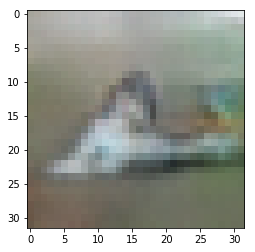

In [116]:
# a sample image

from keras.models import load_model

model = load_model('generator_model_030.h5')
vector = np.asarray([[0.98775 for _ in range(100)]])

x= model.predict(vector)
x = (x+1)/2
print("Generated Image")
pyplot.imshow(x[0,:,:])
pyplot.show

Real Image


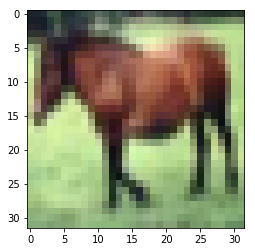

In [76]:
print("Real Image")
pyplot.imshow(x_train[7])